# Playground notebook to explore Snorkel functionalities

In [1]:
import sys
import os
import subprocess
import math

from six import string_types

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import skimage
import cv2
from skimage import io
from skimage import feature
from scipy import ndimage
from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

from PIL import Image

%matplotlib inline

In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("../data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_JPEG_DIR_TEST = os.path.join(PLANET_KAGGLE_ROOT, 'test-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR_TEST)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [382]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [383]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [384]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

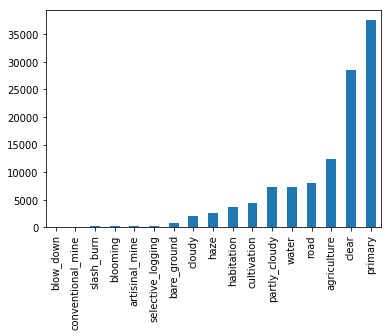

In [170]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

clear  partly_cloudy  haze  cloudy
clear          28431              0     0       0
partly_cloudy      0           7261     0       0
haze               0              0  2697       0
cloudy             0              0     0    2089

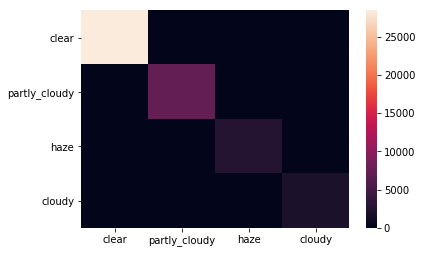

In [7]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix

weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

In [8]:
def sample_images(tags, n=None, complement=False):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == (not complement)
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [73]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            ##########print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx=0, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.at[sample_df.index[row_idx], 'image_name']
    return '{}.{}'.format(fname, suffix)

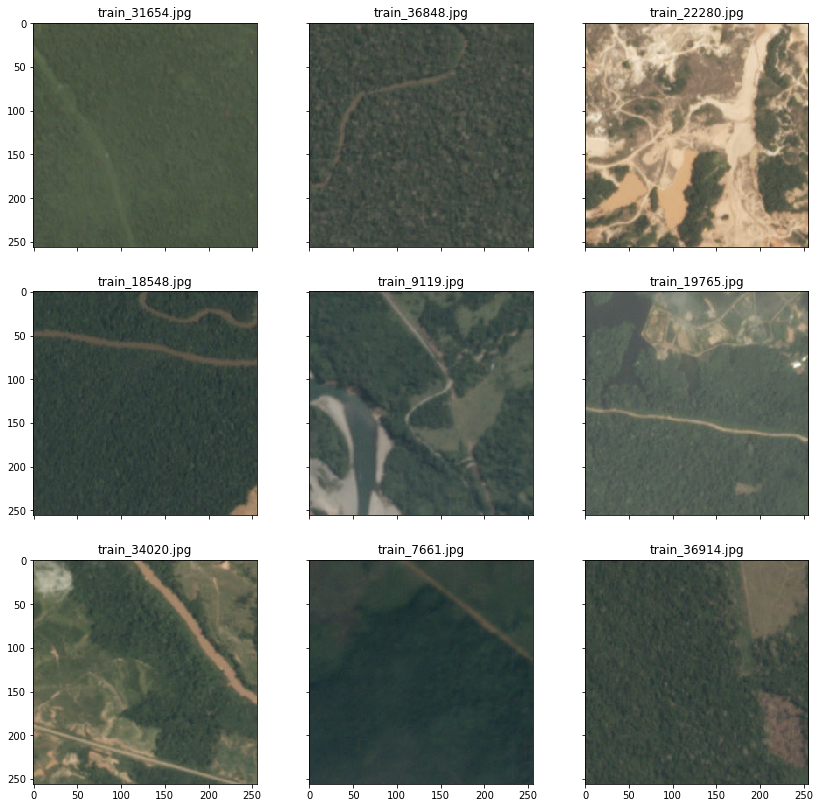

In [10]:
sampled_images = sample_images(['clear', 'road', 'water'], n=9)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]        
        
        ax[i // 3, i % 3].imshow(jpg_img)
        ax[i // 3, i % 3].set_title(jpg)
    except:
        continue

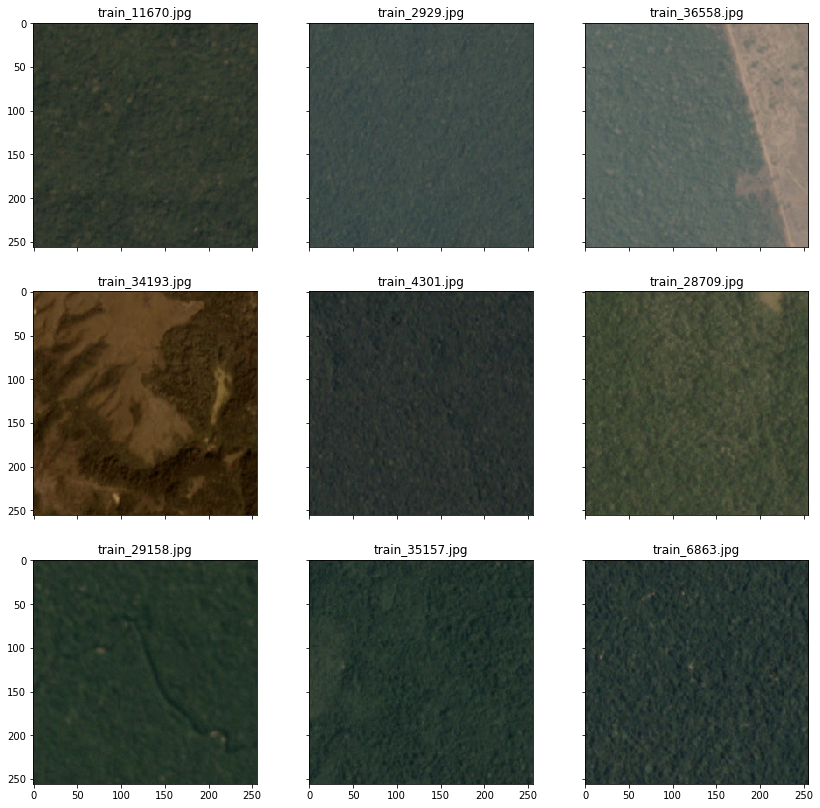

In [11]:
sampled_images = sample_images(['clear'], n=9)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]

        ax[i // 3, i % 3].imshow(jpg_img)
        ax[i // 3, i % 3].set_title(jpg)
    except:
        continue

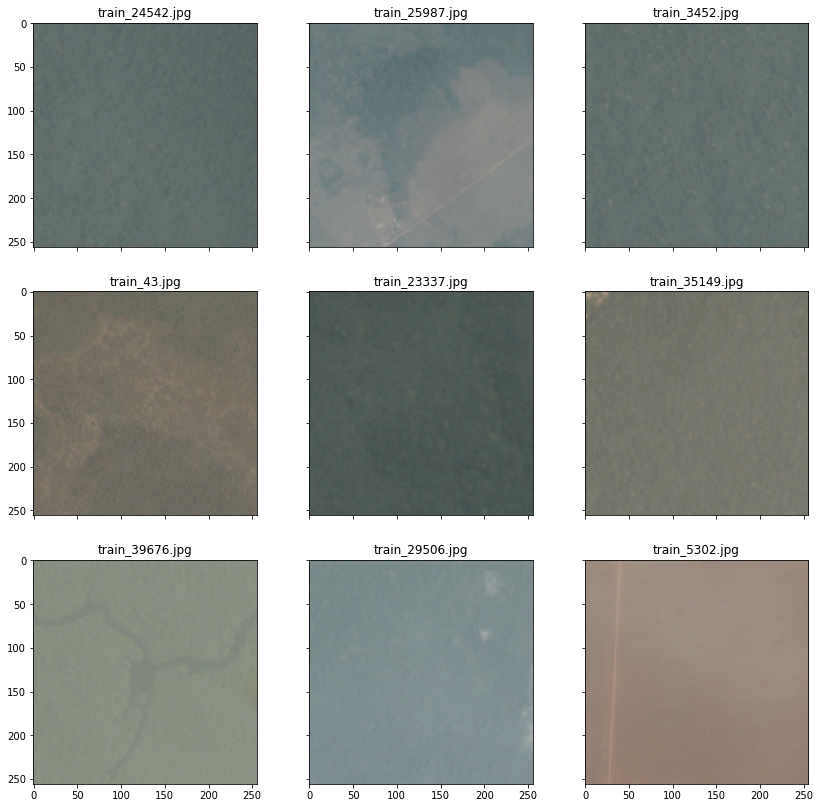

In [12]:
sampled_images = sample_images(['haze'], n=9)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]

        ax[i // 3, i % 3].imshow(jpg_img)
        ax[i // 3, i % 3].set_title(jpg)
    except:
        continue

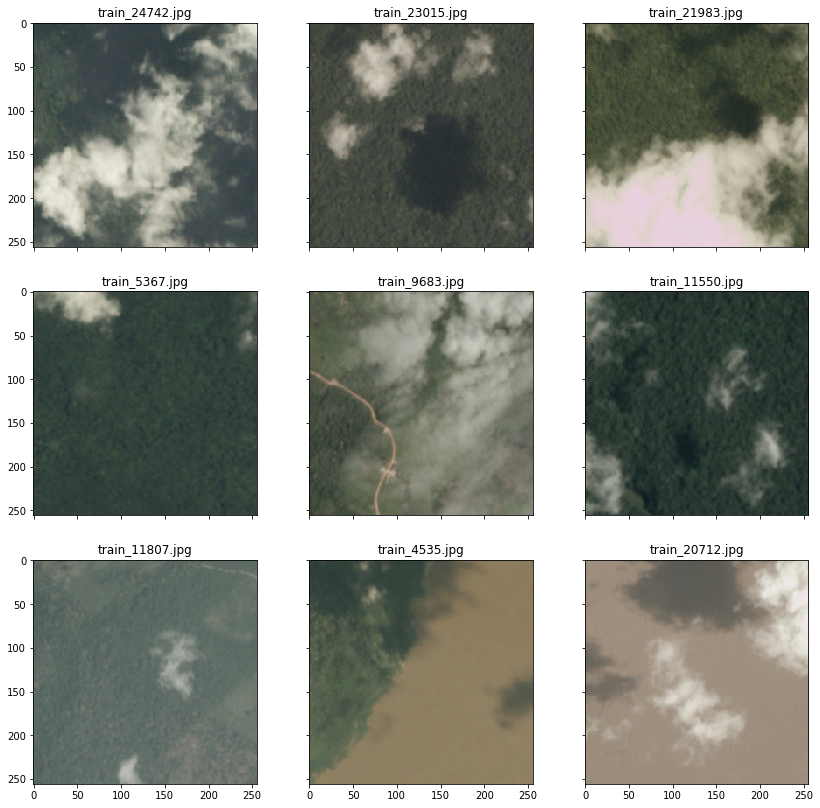

In [13]:
sampled_images = sample_images(['partly_cloudy'], n=9)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]

        ax[i // 3, i % 3].imshow(jpg_img)
        ax[i // 3, i % 3].set_title(jpg)
    except:
        continue

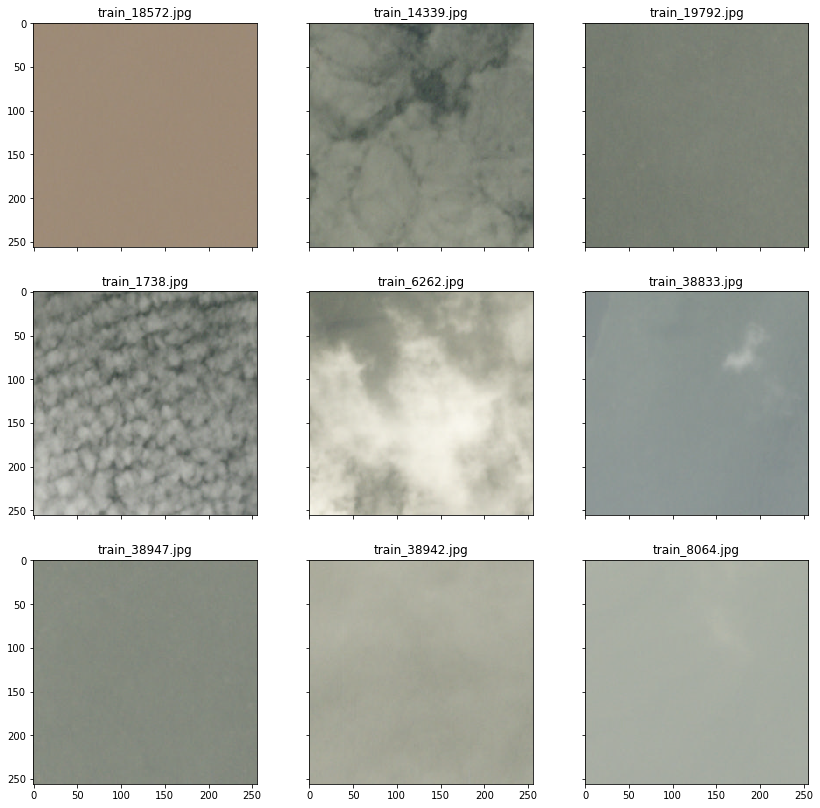

In [32]:
sampled_images = sample_images(['cloudy'], n=9)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]

        ax[i // 3, i % 3].imshow(jpg_img)
        ax[i // 3, i % 3].set_title(jpg)
    except:
        continue

## Labeling functions

In [55]:
size_train_data = labels_df.shape[0]

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def evaluate_LF(LF, tag, n=1000, full_dataset = False):
    #print(namestr(LF, globals()))
    
    if full_dataset:
        n = labels_df[tag].sum()
        n_comp = size_train_data - n
    else:
        n_comp = n
    
    sampled_images = sample_images([tag], n)
    out = LF(sampled_images)
    print('true positives: ', sum(out))
    print('true positives ratio: ', sum(out)/len(sampled_images)) 

    sampled_images_c = sample_images([tag], n_comp, complement=True)
    out_c = LF(sampled_images_c)
    print('false positives: ', sum(out_c))
    print('false positives ratio: ', sum(out_c)/len(sampled_images_c))

    print('accuracy', (sum(out) + len(sampled_images_c) - sum(out_c))\
          /(len(sampled_images) + len(sampled_images_c)))

### Cloudy

In [56]:
#cloudy labelling function no. 1

def cloudy_LF1(images):
    
    out = np.zeros(len(images))
    
    for i in range(len(images)):
        jpg = sample_to_fname(images, i, 'jpg')

        try:
            jpg_img = load_image(jpg)[:,:,:3]
            cloudy_percentile = np.percentile(jpg_img, 40)
            
            if cloudy_percentile > 130:
                out[i] = 1
            else:
                out[i] = 0
            
        except:
            continue
            
    return out
    

In [57]:
evaluate_LF(cloudy_LF1, 'cloudy', full_dataset = True)

true positives:  1650.0
true positives ratio:  0.7898516036381044
false positives:  1602.0
false positives ratio:  0.04172961708778328
accuracy 0.9495787939425381


In [58]:
#cloudy labelling function no. 2

def cloudy_LF2(images):
    
    out = np.zeros(len(images))
    
    for i in range(len(images)):
        jpg = sample_to_fname(images, i, 'jpg')

        try:
            jpg_img = load_image(jpg)[:,:,:3]     
            cloudy_percentile = np.percentile(jpg_img, 80)
            
            if cloudy_percentile > 140:
                out[i] = 1
            else:
                out[i] = 0
            
        except:
            continue
            
    return out

In [74]:
evaluate_LF(cloudy_LF2, 'cloudy')

true positives:  815.0
true positives ratio:  0.815
false positives:  84.0
false positives ratio:  0.084
accuracy 0.8655


### Partly_cloudy

In [33]:
#partly_cloudy labelling function no. 1

def partly_cloudy_LF1(images):
    
    out = np.zeros(len(images))
    
    for i in range(len(images)):
        jpg = sample_to_fname(images, i, 'jpg')

        try:
            jpg_img = load_image(jpg)[:,:,:3]
            
            percentile = np.percentile(jpg_img, 80) - np.percentile(jpg_img, 30)
            
            if percentile > 15:
                out[i] = 1
            else:
                out[i] = 0
            
        except:
            continue
            
    return out

In [60]:
evaluate_LF(partly_cloudy_LF1, 'partly_cloudy')

true positives:  660.0
true positives ratio:  0.66
false positives:  345.0
false positives ratio:  0.345
accuracy 0.6575


In [41]:
#partly_cloudy labelling function no. 2

def partly_cloudy_LF2(images):
    
    out = np.zeros(len(images))
    
    for i in range(len(images)):
        jpg = sample_to_fname(images, i, 'jpg')

        try:
            jpg_img = load_image(jpg)[:,:,:3]
            
            percentile = np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)
            
            if percentile > 40:
                out[i] = 1
            else:
                out[i] = 0
            
        except:
            continue
            
    return out

In [61]:
evaluate_LF(partly_cloudy_LF2, 'partly_cloudy')

true positives:  854.0
true positives ratio:  0.854
false positives:  369.0
false positives ratio:  0.369
accuracy 0.7425


### Haze

In [35]:
#haze labelling function no. 1

def haze_LF1(images):
    
    out = np.zeros(len(images))
    
    for i in range(len(images)):
        jpg = sample_to_fname(images, i, 'jpg')


        jpg_img = load_image(jpg)[:,:,:3]

        percentile = np.percentile(jpg_img, 80)

        if 100 < percentile < 145:
            out[i] = 1
        else:
            out[i] = 0

            
    return out

In [62]:
evaluate_LF(haze_LF1, 'haze')

true positives:  726.0
true positives ratio:  0.726
false positives:  225.0
false positives ratio:  0.225
accuracy 0.7505


In [37]:
#haze labelling function no. 2

def haze_LF2(images):
    
    out = np.zeros(len(images))
    
    for i in range(len(images)):
        jpg = sample_to_fname(images, i, 'jpg')


        jpg_img = load_image(jpg)[:,:,:3]

        percentile = np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)

        if 15 <= percentile <= 26:
            out[i] = 1
        else:
            out[i] = 0

            
    return out

In [63]:
evaluate_LF(haze_LF2, 'haze')

true positives:  564.0
true positives ratio:  0.564
false positives:  159.0
false positives ratio:  0.159
accuracy 0.7025


### Clear

In [39]:
#clear labelling function no. 1

def clear_LF1(images):
    
    out = np.zeros(len(images))
    
    for i in range(len(images)):
        jpg = sample_to_fname(images, i, 'jpg')


        jpg_img = load_image(jpg)[:,:,:3]

        percentile = np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)

        if 24 < percentile < 40:
            out[i] = 1
        else:
            out[i] = 0

            
    return out

In [64]:
evaluate_LF(clear_LF1, 'clear')

true positives:  489.0
true positives ratio:  0.489
false positives:  166.0
false positives ratio:  0.166
accuracy 0.6615


In [65]:
#clear labelling function no. 2

def clear_LF2(images):
    
    out = np.zeros(len(images))
    
    for i in range(len(images)):
        jpg = sample_to_fname(images, i, 'jpg')


        jpg_img = load_image(jpg)[:,:,:3]

        percentile = np.percentile(jpg_img, 98)

        if percentile < 105:
            out[i] = 1
        else:
            out[i] = 0

            
    return out

In [66]:
evaluate_LF(clear_LF2, 'clear')

true positives:  674.0
true positives ratio:  0.674
false positives:  133.0
false positives ratio:  0.133
accuracy 0.7705


## Snorkel

In [192]:
from snorkel.labeling import labeling_function, LabelModel, PandasLFApplier, LFAnalysis, MajorityLabelVoter

### 4 weather classes

In [171]:
# Define the label mappings for convenience
ABSTAIN = -1
CLEAR = 0
PARTLY_CLOUDY = 1
HAZE = 2
CLOUDY = 3

In [197]:
# Add wather labels as integers based on label mapping
df_train = labels_df.copy()
df_train['label'] = df_train['clear']*CLEAR + df_train['partly_cloudy']*PARTLY_CLOUDY + \
                    df_train['haze']*HAZE + df_train['cloudy']*CLOUDY
for label in label_list:
    del df_train[label]
df_train.head()

image_name                                       tags  label
0    train_0                               haze primary      2
1    train_1            agriculture clear primary water      0
2    train_2                              clear primary      0
3    train_3                              clear primary      0
4    train_4  agriculture clear habitation primary road      0

In [198]:
# Split data set into training, development and validation sets

df_train, df_dev, df_valid = df_train[:34000], df_train[34000:35000], df_train[35000:]
print(df_train.shape, df_dev.shape, df_valid.shape)

# Pull out the label vectors for ease of use later
Y_train = df_train.label.values
Y_dev = df_dev.label.values
Y_valid = df_valid.label.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000, 3) (1000, 3) (5479, 3)
(34000,) (1000,) (5479,)
[2 0 0 ... 2 0 0]


In [102]:
@labeling_function()
def cloudy_LF1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLOUDY if np.percentile(jpg_img, 40) > 130 else ABSTAIN

In [103]:
@labeling_function()
def cloudy_LF2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLOUDY if np.percentile(jpg_img, 80) > 140 else ABSTAIN

In [214]:
@labeling_function()
def partly_cloudy_LF1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return PARTLY_CLOUDY if (np.percentile(jpg_img, 80) - np.percentile(jpg_img, 30)) > 15 else ABSTAIN

In [215]:
@labeling_function()
def partly_cloudy_LF2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return PARTLY_CLOUDY if (np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) > 40 else ABSTAIN

In [106]:
@labeling_function()
def haze_LF1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return HAZE if (100 < np.percentile(jpg_img, 80) < 145) else ABSTAIN

In [107]:
@labeling_function()
def haze_LF2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return HAZE if (15 <=(np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) <= 26) else ABSTAIN

In [108]:
@labeling_function()
def clear_LF1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLEAR if (24 <(np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) < 40) else ABSTAIN

In [109]:
@labeling_function()
def clear_LF2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLEAR if np.percentile(jpg_img, 5) < 105 else ABSTAIN

In [110]:
# Define the set of labeling functions (LFs)
lfs = [cloudy_LF1, cloudy_LF2, partly_cloudy_LF1, partly_cloudy_LF2, haze_LF1, haze_LF2, clear_LF1, clear_LF2]

In [185]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)
L_valid = applier.apply(df=df_valid)


  2%|▏         | 809/34000 [00:39<22:53, 24.17it/s]


  5%|▍         | 1689/34000 [01:16<22:48, 23.61it/s]


  8%|▊         | 2565/34000 [01:54<22:58, 22.80it/s]


 10%|█         | 3441/34000 [02:31<22:23, 22.75it/s]


 13%|█▎        | 4318/34000 [03:09<22:30, 21.98it/s]


 15%|█▌        | 5194/34000 [03:47<21:33, 22.26it/s]


 18%|█▊        | 6040/34000 [04:26<19:35, 23.79it/s]


 20%|██        | 6858/34000 [05:06<27:53, 16.22it/s]


 23%|██▎       | 7716/34000 [05:45<25:52, 16.93it/s]


 25%|██▌       | 8555/34000 [06:24<17:04, 24.83it/s]


 28%|██▊       | 9402/34000 [07:04<30:59, 13.23it/s]


 30%|███       | 10260/34000 [07:43<17:00, 23.27it/s]


 33%|███▎      | 11109/34000 [08:22<17:40, 21.59it/s]


 35%|███▌      | 11964/34000 [09:00<18:52, 19.45it/s]


 38%|███▊      | 12815/34000 [09:38<15:23, 22.95it/s]


 40%|████      | 13655/34000 [10:17<15:29, 21.89it/s]


 43%|████▎     | 14502/34000 [10:55<17:04, 19.04it/s]


 45%|████▌     | 15323/34000 [11:34<18:09, 17.15it/s]


 48%|████▊     | 16153/34000 [12:12<12:56, 22.99it/s]


 50%|█████     | 17006/34000 [12:50<11:57, 23.67it/s]


 53%|█████▎    | 17851/34000 [13:28<13:40, 19.69it/s]


 55%|█████▌    | 18701/34000 [14:07<11:18, 22.53it/s]


 58%|█████▊    | 19555/34000 [14:44<10:11, 23.61it/s]


 60%|██████    | 20413/34000 [15:21<10:01, 22.57it/s]


 63%|██████▎   | 21266/34000 [15:58<10:23, 20.43it/s]


 65%|██████▍   | 22093/34000 [16:36<08:21, 23.75it/s]


 68%|██████▊   | 22951/34000 [17:13<07:56, 23.21it/s]


 70%|██████▉   | 23789/34000 [17:51<07:02, 24.18it/s]


 72%|███████▏  | 24643/34000 [18:28<06:40, 23.36it/s]


 75%|███████▍  | 25403/34000 [19:09<06:07, 23.38it/s]


 77%|███████▋  | 26163/34000 [19:47<05:42, 22.91it/s]


 79%|███████▉  | 27001/34000 [20:26<04:56, 23.62it/s]


 82%|████████▏ | 27859/34000 [21:03<04:29, 22.75it/s]


 84%|████████▍ | 28665/34000 [21:42<04:10, 21.34it/s]


 87%|████████▋ | 29458/34000 [22:21<03:23, 22.29it/s]


 89%|████████▉ | 30266/34000 [23:00<03:43, 16.74it/s]


 92%|█████████▏| 31117/34000 [23:38<02:10, 22.02it/s]


 94%|█████████▍| 31974/34000 [24:16<01:32, 21.81it/s]


 97%|█████████▋| 32825/34000 [24:54<00:58, 20.24it/s]


 99%|█████████▉| 33604/34000 [25:32<00:20, 19.62it/s]


100%|██████████| 34000/34000 [25:52<00:00, 21.90it/s]

 40%|███▉      | 399/1000 [00:20<00:28, 20.86it/s]


100%|██████████| 1000/1000 [00:47<00:00, 20.98it/s][A

  5%|▌         | 274/5479 [00:13<04:35, 18.90it/s]


 19%|█▉        | 1040/5479 [00:54<03:58, 18.62it/s]


 33%|███▎      | 1815/5479 [01:37<02:41, 22.68it/s]


 49%|████▉     | 2703/5479 [02:16<02:05, 22.15it/s]


 65%|██████▌   | 3586/5479 [02:56<01:27, 21.55it/s]


 82%|████████▏ | 4472/5479 [03:37<00:45, 22.09it/s]


 97%|█████████▋| 5340/5479 [04:16<00:07, 19.25it/s]


100%|██████████| 5479/5479 [04:23<00:00, 20.82it/s]


In [188]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

j Polarity  Coverage  Overlaps  Conflicts  Correct  \
cloudy_LF1         0      [3]     0.079     0.079      0.073       42   
cloudy_LF2         1      [3]     0.112     0.112      0.106       42   
partly_cloudy_LF1  2      [1]     0.366     0.366      0.366      117   
partly_cloudy_LF2  3      [1]     0.434     0.434      0.434      162   
haze_LF1           4      [2]     0.234     0.233      0.222       50   
haze_LF2           5      [2]     0.184     0.184      0.173       36   
clear_LF1          6      [0]     0.427     0.427      0.137      376   
clear_LF2          7      [0]     0.892     0.881      0.591      672   

                   Incorrect  Emp. Acc.  
cloudy_LF1                37   0.531646  
cloudy_LF2                70   0.375000  
partly_cloudy_LF1        249   0.319672  
partly_cloudy_LF2        272   0.373272  
haze_LF1                 184   0.213675  
haze_LF2                 148   0.195652  
clear_LF1                 51   0.880562  
clear_LF2                220   0.753363

In [191]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=Y_train)

j Polarity  Coverage  Overlaps  Conflicts  Correct  \
cloudy_LF1         0      [3]  0.081088  0.081088   0.076676     1407   
cloudy_LF2         1      [3]  0.121971  0.121971   0.117559     1464   
partly_cloudy_LF1  2      [1]  0.391971  0.391971   0.391971     3862   
partly_cloudy_LF2  3      [1]  0.440853  0.440853   0.440853     5188   
haze_LF1           4      [2]  0.233324  0.231353   0.216971     1641   
haze_LF2           5      [2]  0.185176  0.185176   0.170794     1291   
clear_LF1          6      [0]  0.408500  0.408500   0.127324    12173   
clear_LF2          7      [0]  0.887647  0.881471   0.600294    23245   

                   Incorrect  Emp. Acc.  
cloudy_LF1              1350   0.510337  
cloudy_LF2              2683   0.353026  
partly_cloudy_LF1       9465   0.289788  
partly_cloudy_LF2       9801   0.346120  
haze_LF1                6292   0.206857  
haze_LF2                5005   0.205051  
clear_LF1               1716   0.876449  
clear_LF2               6935   0.770212

In [223]:
#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=1000)
print(L_train)

[[-1 -1 -1 ...  2  0  0]
 [-1 -1  1 ... -1 -1  0]
 [-1 -1 -1 ... -1  0  0]
 ...
 [-1 -1 -1 ...  2 -1  0]
 [-1 -1 -1 ...  2  0  0]
 [-1 -1 -1 ... -1 -1  0]]


In [226]:
majority_model = MajorityLabelVoter(cardinality=4)
preds_train = majority_model.predict(L=L_train, tie_break_policy="abstain")

In [227]:
preds_train

array([-1,  1,  0, ...,  2,  0, -1])

In [228]:
label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [229]:
majority_acc = majority_model.score(L=L_valid, Y=Y_valid, tie_break_policy="abstain")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid, Y=Y_valid, tie_break_policy="abstain")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   66.0%
Label Model Accuracy:     57.4%


In [230]:
preds_train = majority_model.predict(L=L_train, tie_break_policy="random")

In [231]:
label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [232]:
majority_acc = majority_model.score(L=L_valid, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   61.2%
Label Model Accuracy:     57.4%


### 2 weather classes

In [205]:
# Define the label mappings for convenience
ABSTAIN = -1
CLEAR = 0
NOT_CLEAR = 1

In [236]:
# Add wather labels as integers based on label mapping
df_train_2 = labels_df.copy()
df_train_2['label'] = df_train_2['clear']*CLEAR + df_train_2['partly_cloudy']*NOT_CLEAR + \
                    df_train_2['haze']*NOT_CLEAR + df_train_2['cloudy']*NOT_CLEAR
for label in label_list:
    del df_train_2[label]
df_train_2.head()

image_name                                       tags  label
0    train_0                               haze primary      1
1    train_1            agriculture clear primary water      0
2    train_2                              clear primary      0
3    train_3                              clear primary      0
4    train_4  agriculture clear habitation primary road      0

In [237]:
# Split data set into training, development and validation sets

df_train_2, df_dev_2, df_valid_2 = df_train_2[:34000], df_train_2[34000:35000], df_train_2[35000:]
print(df_train_2.shape, df_dev_2.shape, df_valid_2.shape)

# Pull out the label vectors for ease of use later
Y_train_2 = df_train_2.label.values
Y_dev_2 = df_dev_2.label.values
Y_valid_2 = df_valid_2.label.values

print(Y_train_2.shape, Y_dev_2.shape, Y_valid_2.shape)
print(Y_train_2)

(34000, 3) (1000, 3) (5479, 3)
(34000,) (1000,) (5479,)
[1 0 0 ... 1 0 0]


In [238]:
@labeling_function()
def cloudy_LF1_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return NOT_CLEAR if np.percentile(jpg_img, 40) > 130 else ABSTAIN

In [239]:
@labeling_function()
def cloudy_LF2_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return NOT_CLEAR if np.percentile(jpg_img, 80) > 140 else ABSTAIN

In [240]:
@labeling_function()
def partly_cloudy_LF1_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return NOT_CLEAR if (np.percentile(jpg_img, 80) - np.percentile(jpg_img, 30)) > 15 else ABSTAIN

In [241]:
@labeling_function()
def partly_cloudy_LF2_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return NOT_CLEAR if (np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) > 40 else ABSTAIN

In [242]:
@labeling_function()
def haze_LF1_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return NOT_CLEAR if (100 < np.percentile(jpg_img, 80) < 145) else ABSTAIN

In [243]:
@labeling_function()
def haze_LF2_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return NOT_CLEAR if (15 <=(np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) <= 26) else ABSTAIN

In [244]:
@labeling_function()
def clear_LF1_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLEAR if (24 <(np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) < 40) else NOT_CLEAR

In [245]:
@labeling_function()
def clear_LF2_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLEAR if np.percentile(jpg_img, 5) < 105 else NOT_CLEAR

In [246]:
# Define the set of labeling functions (LFs)
lfs_2 = [cloudy_LF1_2, cloudy_LF2_2, partly_cloudy_LF1_2, partly_cloudy_LF2_2, haze_LF1_2, \
         haze_LF2_2, clear_LF1_2, clear_LF2_2]

In [247]:
# Apply the LFs to the unlabeled training data
applier_2 = PandasLFApplier(lfs=lfs_2)
L_train_2 = applier_2.apply(df=df_train_2)
L_dev_2 = applier_2.apply(df=df_dev_2)
L_valid_2 = applier_2.apply(df=df_valid_2)

/Users/rotti/anaconda3/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel

  2%|▏         | 799/34000 [00:38<24:04, 22.98it/s]


  5%|▍         | 1678/34000 [01:17<23:46, 22.66it/s]


  8%|▊         | 2554/34000 [01:55<22:31, 23.27it/s]


 10%|█         | 3419/34000 [02:34<24:21, 20.93it/s]


 13%|█▎        | 4295/34000 [03:13<25:39, 19.30it/s]


 15%|█▌        | 5168/34000 [03:54<22:56, 20.95it/s]


 18%|█▊        | 6039/34000 [04:33<20:45, 22.45it/s]


 20%|██        | 6904/34000 [05:13<19:28, 23.19it/s]


 23%|██▎       | 7780/34000 [05:51<19:24, 22.52it/s]


 25%|██▌       | 8640/34000 [06:30<19:17, 21.91it/s]


 28%|██▊       | 9500/34000 [07:10<17:47, 22.96it/s]


 30%|███       | 10273/34000 [07:48<16:34, 23.86it/s]


 33%|███▎      | 11079/34000 [08:27<16:21, 23.35it/s]


 35%|███▌      | 11933/34000 [09:05<16:17, 22.58it/s]


 37%|███▋      | 12715/34000 [09:43<20:12, 17.55it/s]


 40%|███▉      | 13547/34000 [10:21<14:33, 23.42it/s]


 42%|████▏     | 14312/34000 [10:58<21:57, 14.94it/s]


 44%|████▍     | 15130/34000 [11:37<14:44, 21.34it/s]


 47%|████▋     | 15981/34000 [12:15<12:53, 23.30it/s]


 50%|████▉     | 16838/34000 [12:51<12:21, 23.16it/s]


 52%|█████▏    | 17612/34000 [13:33<12:17, 22.21it/s]


 54%|█████▍    | 18468/34000 [14:11<10:37, 24.38it/s]


 57%|█████▋    | 19300/34000 [14:49<10:22, 23.61it/s]


 59%|█████▉    | 20124/34000 [15:28<10:57, 21.11it/s]


 62%|██████▏   | 20974/34000 [16:05<08:59, 24.13it/s]


 64%|██████▍   | 21823/34000 [16:43<08:17, 24.48it/s]


 67%|██████▋   | 22662/34000 [17:21<07:55, 23.86it/s]


 69%|██████▉   | 23509/34000 [17:58<07:21, 23.74it/s]


 72%|███████▏  | 24366/34000 [18:35<06:28, 24.80it/s]


 74%|███████▍  | 25223/34000 [19:12<06:19, 23.12it/s]


 77%|███████▋  | 26027/34000 [19:51<06:00, 22.14it/s]


 79%|███████▉  | 26884/34000 [20:28<04:57, 23.92it/s]


 82%|████████▏ | 27717/34000 [21:08<05:37, 18.59it/s]


 84%|████████▍ | 28572/34000 [21:45<04:03, 22.29it/s]


 87%|████████▋ | 29421/34000 [22:22<03:19, 22.91it/s]


 89%|████████▉ | 30276/34000 [22:59<02:39, 23.41it/s]


 92%|█████████▏| 31113/34000 [23:37<02:31, 19.06it/s]


 94%|█████████▍| 31960/34000 [24:16<01:26, 23.48it/s]


 96%|█████████▋| 32810/34000 [24:55<00:49, 23.89it/s]


 99%|█████████▉| 33668/34000 [25:32<00:14, 22.90it/s]


100%|██████████| 34000/34000 [25:47<00:00, 21.97it/s]

 53%|█████▎    | 534/1000 [00:24<00:19, 24.22it/s]


100%|██████████| 1000/1000 [00:47<00:00, 21.08it/s]

  6%|▌         | 334/5479 [00:17<03:44, 22.90it/s]


 23%|██▎       | 1237/5479 [00:57<03:00, 23.49it/s]


 39%|███▉      | 2125/5479 [01:37<02:27, 22.72it/s]


 54%|█████▍    | 2975/5479 [02:18<02:10, 19.20it/s]


 70%|██████▉   | 3829/5479 [02:59<01:14, 22.18it/s]


 85%|████████▍ | 4655/5479 [03:39<00:41, 19.72it/s]


 97%|█████████▋| 5337/5479 [04:16<00:06, 20.33it/s]


100%|██████████| 5479/5479 [04:24<00:00, 20.72it/s]


In [248]:
LFAnalysis(L=L_train_2, lfs=lfs_2).lf_summary(Y=Y_train_2)

j Polarity  Coverage  Overlaps  Conflicts  Correct  \
cloudy_LF1_2         0      [1]  0.081088  0.081088   0.022088     2353   
cloudy_LF2_2         1      [1]  0.121971  0.121971   0.057118     3142   
partly_cloudy_LF1_2  2      [1]  0.391971  0.391971   0.353118     4973   
partly_cloudy_LF2_2  3      [1]  0.440853  0.440853   0.397882     6158   
haze_LF1_2           4      [1]  0.233324  0.233324   0.201941     3965   
haze_LF2_2           5      [1]  0.185176  0.185176   0.146912     2149   
clear_LF1_2          6   [0, 1]  1.000000  1.000000   0.629147    20578   
clear_LF2_2          7   [0, 1]  1.000000  1.000000   0.629147    26431   

                     Incorrect  Emp. Acc.  
cloudy_LF1_2               404   0.853464  
cloudy_LF2_2              1005   0.757656  
partly_cloudy_LF1_2       8354   0.373152  
partly_cloudy_LF2_2       8831   0.410835  
haze_LF1_2                3968   0.499811  
haze_LF2_2                4147   0.341328  
clear_LF1_2              13422   0.605235  
clear_LF2_2               7569   0.777382

In [269]:
np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(L_train_2[:,np.r_[1:3, 6:8]])

[[-1 -1  0  0]
 [-1  1  1  0]
 [-1 -1  0  0]
 ...
 [-1 -1  1  0]
 [-1 -1  0  0]
 [-1 -1  1  0]]


In [270]:
majority_model_2 = MajorityLabelVoter(cardinality=2)
preds_train_2 = majority_model_2.predict(L=L_train_2[:,np.r_[1:3, 6:8]], tie_break_policy="abstain")
preds_train_2

array([ 0,  1,  0, ..., -1,  0, -1])

In [271]:
label_model_2 = LabelModel(cardinality=2, verbose=True)
label_model_2.fit(L_train=L_train_2[:,np.r_[1:3, 6:8]], n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [272]:
majority_acc_2 = majority_model_2.score(L=L_valid_2[:,np.r_[1:3, 6:8]], Y=Y_valid_2, tie_break_policy="abstain")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc_2 * 100:.1f}%")

label_model_acc_2 = label_model_2.score(L=L_valid_2[:,np.r_[1:3, 6:8]], Y=Y_valid_2, tie_break_policy="abstain")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc_2 * 100:.1f}%")

Majority Vote Accuracy:   69.0%
Label Model Accuracy:     61.3%


### Balanced data set - 4 weather classes

In [292]:
# Define the label mappings for convenience
ABSTAIN = -1
CLEAR = 0
PARTLY_CLOUDY = 1
HAZE = 2
CLOUDY = 3

In [343]:
# Add wather labels as integers based on label mapping
df_train_3 = labels_df.copy()
df_train_3['label'] = df_train_3['clear']*CLEAR + df_train_3['partly_cloudy']*PARTLY_CLOUDY + \
                    df_train_3['haze']*HAZE + df_train_3['cloudy']*CLOUDY


In [346]:
# Balance data set
#MIN_NO_OF_LABELS = 2089
label_list_weather = ['clear','cloudy','partly_cloudy', 'haze']
MIN_NO_OF_LABELS = labels_df[label_list_weather].sum().min()
print(MIN_NO_OF_LABELS)

# the first MIN_NO_OF_LABELS rows in each group
#df_train_3 = df_train_3.sort_values(['clear','cloudy','partly_cloudy', 'haze'])
#df_train_3.head(30)
#df_train_bal = pd.concat([df_train_3.groupby('clear').head(MIN_NO_OF_LABELS),\
#                        df_train_3.groupby('cloudy').head(MIN_NO_OF_LABELS),\
#                        df_train_3.groupby('partly_cloudy').head(MIN_NO_OF_LABELS),\
#                        df_train_3.groupby('haze').head(MIN_NO_OF_LABELS)])

df_train_bal = pd.concat([df_train_3.loc[df_train_3['clear']==1].head(MIN_NO_OF_LABELS),\
                        df_train_3.loc[df_train_3['cloudy']==1].head(MIN_NO_OF_LABELS),\
                        df_train_3.loc[df_train_3['partly_cloudy']==1].head(MIN_NO_OF_LABELS),\
                        df_train_3.loc[df_train_3['haze']==1].head(MIN_NO_OF_LABELS)])
    

2089


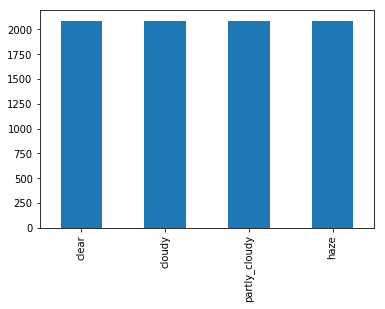

In [348]:
# Histogram of label instances
df_train_bal[label_list_weather].sum().sort_values().plot.bar()

for label in label_list:
    del df_train_bal[label]

In [350]:
print(df_train_bal.shape)
df_train_bal.tail()

(8356, 3)


image_name               tags  label
31180  train_31180       haze primary      2
31188  train_31188       haze primary      2
31198  train_31198       haze primary      2
31205  train_31205  haze primary road      2
31215  train_31215       haze primary      2

In [353]:
# Split data set into training, development and validation sets
df_train_bal = df_train_bal.sample(frac=1)

df_train_3, df_dev_3, df_valid_3 = df_train_bal[:6000], df_train_bal[6000:6500], df_train_bal[6500:]
print(df_train_3.shape, df_dev_3.shape, df_valid_3.shape)

# Pull out the label vectors for ease of use later
Y_train_3 = df_train_3.label.values
Y_dev_3 = df_dev_3.label.values
Y_valid_3 = df_valid_3.label.values

print(Y_train_3.shape, Y_dev_3.shape, Y_valid_3.shape)
print(Y_train_3)

(6000, 3) (500, 3) (1856, 3)
(6000,) (500,) (1856,)
[2 3 3 ... 3 2 1]


In [354]:
# Apply the LFs to the unlabeled training data
L_train_3 = applier.apply(df=df_train_3)
L_dev_3 = applier.apply(df=df_dev_3)
L_valid_3 = applier.apply(df=df_valid_3)

/Users/rotti/anaconda3/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 4/6000 [00:00<03:07, 31.99it/s]

  0%|          | 7/6000 [00:00<03:30, 28.54it/s]

  0%|          | 10/6000 [00:00<03:52, 25.80it/s]

  0%|          | 13/6000 [00:00<04:00, 24.89it/s]

  0%|          | 16/6000 [00:00<04:02, 24.67it/s]

  0%|          | 19/6000 [00:00<04:00, 24.85it/s]

  0%|          | 22/6000 [00:00<04:04, 24.42it/s]

  0%|          | 25/6000 [00:01<04:15, 23.35it/s]

  0%|          | 28/6000 [00:01<04:17, 23.22it/s]

  1%|          | 31/6000 [00:01<04:14, 23.43it/s]

  1%|          | 34/6000 [00:01<04:12, 23.64it/s]

  1%|          | 37/6000 [00:01<04:07, 24.05it/s]

  1%|          | 40/6000 [00:01<04:07, 24.07it/s]

  1%|          | 43/6000 [00:01<04:05, 24.24it/s]

  1%|      

  7%|▋         | 401/6000 [00:18<03:49, 24.41it/s]

  7%|▋         | 404/6000 [00:18<03:53, 23.99it/s]

  7%|▋         | 407/6000 [00:18<03:45, 24.82it/s]

  7%|▋         | 410/6000 [00:18<03:39, 25.48it/s]

  7%|▋         | 413/6000 [00:18<03:41, 25.22it/s]

  7%|▋         | 416/6000 [00:18<03:38, 25.61it/s]

  7%|▋         | 419/6000 [00:18<03:34, 26.01it/s]

  7%|▋         | 422/6000 [00:18<03:38, 25.51it/s]

  7%|▋         | 425/6000 [00:18<03:37, 25.65it/s]

  7%|▋         | 428/6000 [00:19<04:11, 22.13it/s]

  7%|▋         | 431/6000 [00:19<04:59, 18.58it/s]

  7%|▋         | 434/6000 [00:19<05:05, 18.21it/s]

  7%|▋         | 436/6000 [00:19<05:14, 17.68it/s]

  7%|▋         | 438/6000 [00:19<05:15, 17.62it/s]

  7%|▋         | 440/6000 [00:19<05:05, 18.22it/s]

  7%|▋         | 443/6000 [00:20<04:43, 19.59it/s]

  7%|▋         | 446/6000 [00:20<04:30, 20.51it/s]

  7%|▋         | 449/6000 [00:20<04:32, 20.35it/s]

  8%|▊         | 452/6000 [00:20<04:42, 19.62it/s]

  8%|▊      

 21%|██        | 1235/6000 [00:53<03:13, 24.66it/s]

 21%|██        | 1238/6000 [00:53<03:08, 25.30it/s]

 21%|██        | 1241/6000 [00:53<03:15, 24.40it/s]

 21%|██        | 1244/6000 [00:53<03:18, 23.91it/s]

 21%|██        | 1247/6000 [00:53<03:15, 24.29it/s]

 21%|██        | 1250/6000 [00:53<03:13, 24.49it/s]

 21%|██        | 1253/6000 [00:54<03:12, 24.66it/s]

 21%|██        | 1256/6000 [00:54<03:09, 25.07it/s]

 21%|██        | 1259/6000 [00:54<03:09, 24.98it/s]

 21%|██        | 1262/6000 [00:54<03:16, 24.12it/s]

 21%|██        | 1265/6000 [00:54<03:09, 25.02it/s]

 21%|██        | 1268/6000 [00:54<03:09, 24.96it/s]

 21%|██        | 1271/6000 [00:54<03:08, 25.09it/s]

 21%|██        | 1274/6000 [00:54<03:14, 24.30it/s]

 21%|██▏       | 1277/6000 [00:54<03:10, 24.74it/s]

 21%|██▏       | 1280/6000 [00:55<03:15, 24.10it/s]

 21%|██▏       | 1283/6000 [00:55<03:23, 23.17it/s]

 21%|██▏       | 1286/6000 [00:55<03:13, 24.39it/s]

 21%|██▏       | 1289/6000 [00:55<03:08, 24.98

 34%|███▍      | 2063/6000 [01:27<02:41, 24.43it/s]

 34%|███▍      | 2066/6000 [01:27<02:44, 23.86it/s]

 34%|███▍      | 2069/6000 [01:27<02:41, 24.27it/s]

 35%|███▍      | 2072/6000 [01:27<02:40, 24.54it/s]

 35%|███▍      | 2075/6000 [01:27<02:41, 24.35it/s]

 35%|███▍      | 2078/6000 [01:27<02:38, 24.67it/s]

 35%|███▍      | 2081/6000 [01:28<02:37, 24.86it/s]

 35%|███▍      | 2084/6000 [01:28<02:35, 25.23it/s]

 35%|███▍      | 2087/6000 [01:28<02:44, 23.82it/s]

 35%|███▍      | 2090/6000 [01:28<02:39, 24.44it/s]

 35%|███▍      | 2093/6000 [01:28<02:37, 24.77it/s]

 35%|███▍      | 2096/6000 [01:28<02:41, 24.12it/s]

 35%|███▍      | 2099/6000 [01:28<02:42, 23.94it/s]

 35%|███▌      | 2102/6000 [01:28<02:49, 22.93it/s]

 35%|███▌      | 2105/6000 [01:29<02:52, 22.58it/s]

 35%|███▌      | 2108/6000 [01:29<02:52, 22.50it/s]

 35%|███▌      | 2111/6000 [01:29<02:51, 22.74it/s]

 35%|███▌      | 2114/6000 [01:29<02:45, 23.52it/s]

 35%|███▌      | 2117/6000 [01:29<02:44, 23.60

 48%|████▊     | 2893/6000 [02:01<02:10, 23.83it/s]

 48%|████▊     | 2896/6000 [02:01<02:08, 24.22it/s]

 48%|████▊     | 2899/6000 [02:01<02:11, 23.54it/s]

 48%|████▊     | 2902/6000 [02:01<02:11, 23.61it/s]

 48%|████▊     | 2905/6000 [02:01<02:11, 23.50it/s]

 48%|████▊     | 2908/6000 [02:02<02:13, 23.20it/s]

 49%|████▊     | 2911/6000 [02:02<02:15, 22.81it/s]

 49%|████▊     | 2914/6000 [02:02<02:12, 23.38it/s]

 49%|████▊     | 2917/6000 [02:02<02:12, 23.33it/s]

 49%|████▊     | 2920/6000 [02:02<02:11, 23.50it/s]

 49%|████▊     | 2923/6000 [02:02<02:15, 22.65it/s]

 49%|████▉     | 2926/6000 [02:02<02:14, 22.93it/s]

 49%|████▉     | 2929/6000 [02:02<02:08, 23.90it/s]

 49%|████▉     | 2932/6000 [02:03<02:05, 24.46it/s]

 49%|████▉     | 2935/6000 [02:03<02:13, 22.96it/s]

 49%|████▉     | 2938/6000 [02:03<02:10, 23.41it/s]

 49%|████▉     | 2941/6000 [02:03<02:11, 23.24it/s]

 49%|████▉     | 2944/6000 [02:03<02:10, 23.42it/s]

 49%|████▉     | 2947/6000 [02:03<02:12, 23.06

 62%|██████▏   | 3721/6000 [02:35<01:39, 23.01it/s]

 62%|██████▏   | 3724/6000 [02:35<01:38, 23.05it/s]

 62%|██████▏   | 3727/6000 [02:36<01:35, 23.80it/s]

 62%|██████▏   | 3730/6000 [02:36<01:35, 23.81it/s]

 62%|██████▏   | 3733/6000 [02:36<01:33, 24.23it/s]

 62%|██████▏   | 3736/6000 [02:36<01:32, 24.48it/s]

 62%|██████▏   | 3739/6000 [02:36<01:31, 24.71it/s]

 62%|██████▏   | 3742/6000 [02:36<01:31, 24.79it/s]

 62%|██████▏   | 3745/6000 [02:36<01:30, 24.89it/s]

 62%|██████▏   | 3748/6000 [02:36<01:29, 25.27it/s]

 63%|██████▎   | 3751/6000 [02:37<01:28, 25.35it/s]

 63%|██████▎   | 3754/6000 [02:37<01:28, 25.38it/s]

 63%|██████▎   | 3757/6000 [02:37<01:32, 24.18it/s]

 63%|██████▎   | 3760/6000 [02:37<01:30, 24.66it/s]

 63%|██████▎   | 3763/6000 [02:37<01:30, 24.80it/s]

 63%|██████▎   | 3766/6000 [02:37<01:27, 25.66it/s]

 63%|██████▎   | 3769/6000 [02:37<01:28, 25.12it/s]

 63%|██████▎   | 3772/6000 [02:37<01:30, 24.63it/s]

 63%|██████▎   | 3775/6000 [02:38<01:30, 24.71

 76%|███████▌  | 4549/6000 [03:09<01:00, 23.83it/s]

 76%|███████▌  | 4552/6000 [03:09<00:59, 24.29it/s]

 76%|███████▌  | 4555/6000 [03:10<00:58, 24.52it/s]

 76%|███████▌  | 4558/6000 [03:10<00:58, 24.76it/s]

 76%|███████▌  | 4561/6000 [03:10<00:57, 24.89it/s]

 76%|███████▌  | 4564/6000 [03:10<00:56, 25.53it/s]

 76%|███████▌  | 4567/6000 [03:10<00:55, 25.81it/s]

 76%|███████▌  | 4570/6000 [03:10<00:55, 25.69it/s]

 76%|███████▌  | 4573/6000 [03:10<00:55, 25.66it/s]

 76%|███████▋  | 4576/6000 [03:10<00:57, 24.92it/s]

 76%|███████▋  | 4579/6000 [03:10<00:56, 25.30it/s]

 76%|███████▋  | 4582/6000 [03:11<00:56, 24.94it/s]

 76%|███████▋  | 4585/6000 [03:11<00:57, 24.79it/s]

 76%|███████▋  | 4588/6000 [03:11<00:58, 24.32it/s]

 77%|███████▋  | 4591/6000 [03:11<00:58, 24.09it/s]

 77%|███████▋  | 4594/6000 [03:11<00:57, 24.41it/s]

 77%|███████▋  | 4597/6000 [03:11<00:57, 24.53it/s]

 77%|███████▋  | 4600/6000 [03:11<00:58, 23.83it/s]

 77%|███████▋  | 4603/6000 [03:11<00:56, 24.71

 90%|████████▉ | 5378/6000 [03:43<00:26, 23.81it/s]

 90%|████████▉ | 5381/6000 [03:43<00:25, 24.05it/s]

 90%|████████▉ | 5384/6000 [03:43<00:25, 23.85it/s]

 90%|████████▉ | 5387/6000 [03:44<00:26, 23.24it/s]

 90%|████████▉ | 5390/6000 [03:44<00:26, 22.64it/s]

 90%|████████▉ | 5393/6000 [03:44<00:28, 21.46it/s]

 90%|████████▉ | 5396/6000 [03:44<00:27, 22.16it/s]

 90%|████████▉ | 5399/6000 [03:44<00:25, 23.41it/s]

 90%|█████████ | 5402/6000 [03:44<00:25, 23.40it/s]

 90%|█████████ | 5405/6000 [03:44<00:25, 23.60it/s]

 90%|█████████ | 5408/6000 [03:44<00:24, 23.86it/s]

 90%|█████████ | 5411/6000 [03:45<00:23, 24.94it/s]

 90%|█████████ | 5414/6000 [03:45<00:23, 25.01it/s]

 90%|█████████ | 5417/6000 [03:45<00:23, 24.76it/s]

 90%|█████████ | 5420/6000 [03:45<00:23, 24.40it/s]

 90%|█████████ | 5423/6000 [03:45<00:23, 24.49it/s]

 90%|█████████ | 5426/6000 [03:45<00:22, 25.07it/s]

 90%|█████████ | 5429/6000 [03:45<00:22, 25.13it/s]

 91%|█████████ | 5432/6000 [03:45<00:22, 24.72

 42%|████▏     | 208/500 [00:08<00:12, 23.23it/s]

 42%|████▏     | 211/500 [00:09<00:12, 23.54it/s]

 43%|████▎     | 214/500 [00:09<00:11, 24.28it/s]

 43%|████▎     | 217/500 [00:09<00:11, 24.75it/s]

 44%|████▍     | 220/500 [00:09<00:11, 23.83it/s]

 45%|████▍     | 223/500 [00:09<00:11, 23.80it/s]

 45%|████▌     | 226/500 [00:09<00:11, 24.80it/s]

 46%|████▌     | 229/500 [00:09<00:11, 24.56it/s]

 46%|████▋     | 232/500 [00:09<00:10, 24.91it/s]

 47%|████▋     | 235/500 [00:10<00:10, 24.29it/s]

 48%|████▊     | 238/500 [00:10<00:10, 24.34it/s]

 48%|████▊     | 241/500 [00:10<00:10, 24.71it/s]

 49%|████▉     | 244/500 [00:10<00:10, 24.16it/s]

 49%|████▉     | 247/500 [00:10<00:10, 24.09it/s]

 50%|█████     | 250/500 [00:10<00:10, 24.81it/s]

 51%|█████     | 253/500 [00:10<00:10, 24.57it/s]

 51%|█████     | 256/500 [00:10<00:09, 25.26it/s]

 52%|█████▏    | 259/500 [00:11<00:09, 24.89it/s]

 52%|█████▏    | 262/500 [00:11<00:09, 25.55it/s]

 53%|█████▎    | 265/500 [00:11

 29%|██▉       | 539/1856 [00:23<00:49, 26.52it/s]

 29%|██▉       | 542/1856 [00:23<00:50, 25.93it/s]

 29%|██▉       | 545/1856 [00:23<00:52, 24.89it/s]

 30%|██▉       | 548/1856 [00:24<00:54, 23.91it/s]

 30%|██▉       | 551/1856 [00:24<00:54, 23.88it/s]

 30%|██▉       | 554/1856 [00:24<00:54, 23.68it/s]

 30%|███       | 557/1856 [00:24<00:55, 23.55it/s]

 30%|███       | 560/1856 [00:24<00:53, 24.01it/s]

 30%|███       | 563/1856 [00:24<00:53, 24.38it/s]

 30%|███       | 566/1856 [00:24<00:51, 24.85it/s]

 31%|███       | 569/1856 [00:24<00:52, 24.33it/s]

 31%|███       | 572/1856 [00:25<00:53, 23.83it/s]

 31%|███       | 575/1856 [00:25<00:54, 23.44it/s]

 31%|███       | 578/1856 [00:25<00:54, 23.49it/s]

 31%|███▏      | 581/1856 [00:25<00:51, 24.61it/s]

 31%|███▏      | 584/1856 [00:25<00:52, 24.38it/s]

 32%|███▏      | 587/1856 [00:25<00:50, 25.00it/s]

 32%|███▏      | 590/1856 [00:25<00:50, 25.26it/s]

 32%|███▏      | 593/1856 [00:25<00:47, 26.32it/s]

 32%|███▏   

 74%|███████▍  | 1380/1856 [00:58<00:20, 23.42it/s]

 75%|███████▍  | 1383/1856 [00:58<00:20, 23.36it/s]

 75%|███████▍  | 1386/1856 [00:58<00:19, 23.63it/s]

 75%|███████▍  | 1389/1856 [00:58<00:19, 23.88it/s]

 75%|███████▌  | 1392/1856 [00:58<00:18, 24.57it/s]

 75%|███████▌  | 1395/1856 [00:58<00:19, 23.94it/s]

 75%|███████▌  | 1398/1856 [00:58<00:19, 24.10it/s]

 75%|███████▌  | 1401/1856 [00:59<00:18, 24.07it/s]

 76%|███████▌  | 1404/1856 [00:59<00:18, 24.46it/s]

 76%|███████▌  | 1407/1856 [00:59<00:18, 24.40it/s]

 76%|███████▌  | 1410/1856 [00:59<00:18, 24.08it/s]

 76%|███████▌  | 1413/1856 [00:59<00:18, 24.39it/s]

 76%|███████▋  | 1416/1856 [00:59<00:17, 25.04it/s]

 76%|███████▋  | 1419/1856 [00:59<00:17, 24.71it/s]

 77%|███████▋  | 1422/1856 [00:59<00:17, 24.60it/s]

 77%|███████▋  | 1425/1856 [00:59<00:17, 25.17it/s]

 77%|███████▋  | 1428/1856 [01:00<00:16, 25.50it/s]

 77%|███████▋  | 1431/1856 [01:00<00:16, 25.19it/s]

 77%|███████▋  | 1434/1856 [01:00<00:16, 24.84

In [355]:
LFAnalysis(L=L_train_3, lfs=lfs).lf_summary(Y=Y_train_3)

j Polarity  Coverage  Overlaps  Conflicts  Correct  \
cloudy_LF1         0      [3]  0.277833  0.277833   0.257667     1186   
cloudy_LF2         1      [3]  0.321667  0.321667   0.301500     1239   
partly_cloudy_LF1  2      [1]  0.385667  0.385667   0.385667      944   
partly_cloudy_LF2  3      [1]  0.435333  0.435333   0.435333     1287   
haze_LF1           4      [2]  0.351000  0.344167   0.294333     1080   
haze_LF2           5      [2]  0.292333  0.292333   0.242500      856   
clear_LF1          6      [0]  0.275833  0.275833   0.153333      751   
clear_LF2          7      [0]  0.642000  0.638000   0.515500     1466   

                   Incorrect  Emp. Acc.  
cloudy_LF1               481   0.711458  
cloudy_LF2               691   0.641969  
partly_cloudy_LF1       1370   0.407952  
partly_cloudy_LF2       1325   0.492726  
haze_LF1                1026   0.512821  
haze_LF2                 898   0.488027  
clear_LF1                904   0.453776  
clear_LF2               2386   0.380582

In [356]:
majority_model_3 = MajorityLabelVoter(cardinality=4)
preds_train_3 = majority_model_3.predict(L=L_train_3, tie_break_policy="abstain")

In [357]:
label_model_3 = LabelModel(cardinality=4, verbose=True)
label_model_3.fit(L_train=L_train_3, n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [358]:
majority_acc_3 = majority_model.score(L=L_valid_3, Y=Y_valid_3, tie_break_policy="abstain")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc_3 * 100:.1f}%")

label_model_acc_3 = label_model.score(L=L_valid_3, Y=Y_valid_3, tie_break_policy="abstain")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc_3 * 100:.1f}%")

Majority Vote Accuracy:   65.9%
Label Model Accuracy:     57.7%


### Balanced dataset - partly_cloudy and clear

In [371]:
# Define the label mappings for convenience
ABSTAIN = -1
CLEAR = 0
PARTLY_CLOUDY = 1

In [389]:
# Add weather labels as integers based on label mapping
df_train_4 = labels_df.copy()
df_train_4['label'] = df_train_4['clear']*CLEAR + df_train_4['partly_cloudy']*PARTLY_CLOUDY
df_train_4.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  label  
0         0                  0          0      0  
1         0                  0          0      0  
2         0                  0          0      0  
3         0                  0          0      0  
4         0                  0          0      0

In [390]:
# Select data set
label_list_4 = ['clear','partly_cloudy']
MIN_NO_OF_LABELS = labels_df[label_list_4].sum().min()
print(MIN_NO_OF_LABELS)

df_train_bal_4 = pd.concat([df_train_4.loc[df_train_4['clear']==1].head(MIN_NO_OF_LABELS),\
                        df_train_4.loc[df_train_4['partly_cloudy']==1].head(MIN_NO_OF_LABELS)])

for label in label_list:
    del df_train_bal_4[label]
    
df_train_bal_4.head()

7261


image_name                                         tags  label
1    train_1              agriculture clear primary water      0
2    train_2                                clear primary      0
3    train_3                                clear primary      0
4    train_4    agriculture clear habitation primary road      0
6    train_6  agriculture clear cultivation primary water      0

In [391]:
# Split data set into training, development and validation sets
df_train_bal_4 = df_train_bal_4.sample(frac=1)

df_train_4, df_dev_4, df_valid_4 = df_train_bal_4[:11000], df_train_bal_4[11000:11500], df_train_bal_4[11500:]
print(df_train_4.shape, df_dev_4.shape, df_valid_4.shape)

# Pull out the label vectors for ease of use later
Y_train_4 = df_train_4.label.values
Y_dev_4 = df_dev_4.label.values
Y_valid_4 = df_valid_4.label.values

print(Y_train_4.shape, Y_dev_4.shape, Y_valid_4.shape)
print(Y_train_4)

(11000, 3) (500, 3) (3022, 3)
(11000,) (500,) (3022,)
[0 1 0 ... 1 1 0]


In [392]:
@labeling_function()
def partly_cloudy_LF1_4(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return PARTLY_CLOUDY if (np.percentile(jpg_img, 80) - np.percentile(jpg_img, 30)) > 15 else CLEAR

In [393]:
@labeling_function()
def partly_cloudy_LF2_4(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return PARTLY_CLOUDY if (np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) > 40 else CLEAR

In [394]:
@labeling_function()
def clear_LF1_4(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLEAR if (24 <(np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) < 40) else PARTLY_CLOUDY

In [395]:
@labeling_function()
def clear_LF2_4(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLEAR if np.percentile(jpg_img, 5) < 105 else PARTLY_CLOUDY

In [396]:
# Define the set of labeling functions (LFs)
lfs_4 = [partly_cloudy_LF1_4, partly_cloudy_LF2_4, clear_LF1_4, clear_LF2_4]

In [397]:
# Apply the LFs to the unlabeled training data
applier_4 = PandasLFApplier(lfs=lfs_4)
L_train_4 = applier_4.apply(df=df_train_4)
L_dev_4 = applier_4.apply(df=df_dev_4)
L_valid_4 = applier_4.apply(df=df_valid_4)

/Users/rotti/anaconda3/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 3/11000 [00:00<06:44, 27.15it/s]

  0%|          | 7/11000 [00:00<06:15, 29.24it/s]

  0%|          | 11/11000 [00:00<05:53, 31.07it/s]

  0%|          | 15/11000 [00:00<05:40, 32.27it/s]

  0%|          | 20/11000 [00:00<05:28, 33.44it/s]

  0%|          | 24/11000 [00:00<05:29, 33.34it/s]

  0%|          | 28/11000 [00:00<05:27, 33.53it/s]

  0%|          | 32/11000 [00:00<05:14, 34.90it/s]

  0%|          | 36/11000 [00:01<05:19, 34.35it/s]

  0%|          | 40/11000 [00:01<05:28, 33.36it/s]

  0%|          | 44/11000 [00:01<06:39, 27.41it/s]

  0%|          | 47/11000 [00:01<06:47, 26.86it/s]

  0%|          | 51/11000 [00:01<06:19, 28.86it/s]

  0%|          | 55/11000 [00:01<05:50, 31.26it/

 10%|▉         | 1059/11000 [00:33<04:58, 33.28it/s]

 10%|▉         | 1063/11000 [00:33<04:58, 33.30it/s]

 10%|▉         | 1067/11000 [00:33<05:01, 32.93it/s]

 10%|▉         | 1071/11000 [00:33<05:02, 32.77it/s]

 10%|▉         | 1075/11000 [00:34<05:16, 31.39it/s]

 10%|▉         | 1079/11000 [00:34<05:06, 32.40it/s]

 10%|▉         | 1083/11000 [00:34<05:05, 32.49it/s]

 10%|▉         | 1087/11000 [00:34<05:05, 32.42it/s]

 10%|▉         | 1091/11000 [00:34<05:29, 30.10it/s]

 10%|▉         | 1095/11000 [00:34<05:28, 30.20it/s]

 10%|▉         | 1099/11000 [00:34<05:27, 30.22it/s]

 10%|█         | 1103/11000 [00:34<05:17, 31.17it/s]

 10%|█         | 1107/11000 [00:35<05:46, 28.55it/s]

 10%|█         | 1110/11000 [00:35<05:44, 28.75it/s]

 10%|█         | 1113/11000 [00:35<05:47, 28.44it/s]

 10%|█         | 1116/11000 [00:35<05:43, 28.75it/s]

 10%|█         | 1119/11000 [00:35<05:40, 29.01it/s]

 10%|█         | 1123/11000 [00:35<05:29, 29.96it/s]

 10%|█         | 1127/11000 

 20%|█▉        | 2180/11000 [01:06<04:50, 30.40it/s]

 20%|█▉        | 2184/11000 [01:06<05:03, 29.05it/s]

 20%|█▉        | 2187/11000 [01:06<05:06, 28.78it/s]

 20%|█▉        | 2191/11000 [01:06<04:50, 30.31it/s]

 20%|█▉        | 2195/11000 [01:06<04:54, 29.92it/s]

 20%|█▉        | 2199/11000 [01:06<04:37, 31.69it/s]

 20%|██        | 2204/11000 [01:06<04:15, 34.47it/s]

 20%|██        | 2208/11000 [01:07<04:18, 33.95it/s]

 20%|██        | 2212/11000 [01:07<04:12, 34.78it/s]

 20%|██        | 2216/11000 [01:07<04:05, 35.80it/s]

 20%|██        | 2221/11000 [01:07<03:49, 38.24it/s]

 20%|██        | 2226/11000 [01:07<03:37, 40.26it/s]

 20%|██        | 2231/11000 [01:07<03:46, 38.70it/s]

 20%|██        | 2236/11000 [01:07<03:37, 40.23it/s]

 20%|██        | 2241/11000 [01:07<03:39, 39.97it/s]

 20%|██        | 2246/11000 [01:07<03:37, 40.22it/s]

 20%|██        | 2251/11000 [01:08<03:34, 40.80it/s]

 21%|██        | 2256/11000 [01:08<03:37, 40.29it/s]

 21%|██        | 2261/11000 

 30%|███       | 3327/11000 [01:39<03:39, 34.88it/s]

 30%|███       | 3331/11000 [01:39<03:37, 35.34it/s]

 30%|███       | 3335/11000 [01:39<03:32, 36.02it/s]

 30%|███       | 3339/11000 [01:39<03:29, 36.51it/s]

 30%|███       | 3343/11000 [01:39<03:40, 34.73it/s]

 30%|███       | 3347/11000 [01:39<03:48, 33.45it/s]

 30%|███       | 3351/11000 [01:39<03:39, 34.81it/s]

 30%|███       | 3355/11000 [01:39<03:31, 36.06it/s]

 31%|███       | 3360/11000 [01:40<03:20, 38.10it/s]

 31%|███       | 3364/11000 [01:40<03:34, 35.67it/s]

 31%|███       | 3368/11000 [01:40<03:40, 34.59it/s]

 31%|███       | 3372/11000 [01:40<03:52, 32.82it/s]

 31%|███       | 3376/11000 [01:40<03:47, 33.57it/s]

 31%|███       | 3380/11000 [01:40<03:52, 32.71it/s]

 31%|███       | 3385/11000 [01:40<03:44, 34.00it/s]

 31%|███       | 3389/11000 [01:40<03:51, 32.89it/s]

 31%|███       | 3393/11000 [01:41<03:53, 32.51it/s]

 31%|███       | 3398/11000 [01:41<03:38, 34.81it/s]

 31%|███       | 3402/11000 

 41%|████      | 4459/11000 [02:11<03:48, 28.61it/s]

 41%|████      | 4462/11000 [02:12<03:57, 27.52it/s]

 41%|████      | 4465/11000 [02:12<04:07, 26.43it/s]

 41%|████      | 4469/11000 [02:12<03:51, 28.17it/s]

 41%|████      | 4472/11000 [02:12<03:48, 28.57it/s]

 41%|████      | 4476/11000 [02:12<03:37, 30.00it/s]

 41%|████      | 4480/11000 [02:12<03:38, 29.88it/s]

 41%|████      | 4484/11000 [02:12<03:23, 32.00it/s]

 41%|████      | 4488/11000 [02:12<03:13, 33.71it/s]

 41%|████      | 4492/11000 [02:12<03:09, 34.41it/s]

 41%|████      | 4496/11000 [02:13<03:04, 35.30it/s]

 41%|████      | 4500/11000 [02:13<03:07, 34.60it/s]

 41%|████      | 4504/11000 [02:13<03:08, 34.42it/s]

 41%|████      | 4509/11000 [02:13<02:52, 37.64it/s]

 41%|████      | 4514/11000 [02:13<02:44, 39.42it/s]

 41%|████      | 4519/11000 [02:13<02:43, 39.75it/s]

 41%|████      | 4524/11000 [02:13<02:35, 41.55it/s]

 41%|████      | 4529/11000 [02:13<02:36, 41.38it/s]

 41%|████      | 4534/11000 

 52%|█████▏    | 5758/11000 [02:44<02:11, 39.99it/s]

 52%|█████▏    | 5763/11000 [02:44<02:09, 40.56it/s]

 52%|█████▏    | 5768/11000 [02:44<02:04, 42.04it/s]

 52%|█████▏    | 5773/11000 [02:44<02:03, 42.38it/s]

 53%|█████▎    | 5778/11000 [02:45<02:03, 42.33it/s]

 53%|█████▎    | 5783/11000 [02:45<01:59, 43.62it/s]

 53%|█████▎    | 5788/11000 [02:45<02:01, 42.82it/s]

 53%|█████▎    | 5793/11000 [02:45<02:00, 43.19it/s]

 53%|█████▎    | 5798/11000 [02:45<02:05, 41.46it/s]

 53%|█████▎    | 5803/11000 [02:45<02:03, 42.04it/s]

 53%|█████▎    | 5808/11000 [02:45<02:03, 42.14it/s]

 53%|█████▎    | 5813/11000 [02:45<02:03, 42.01it/s]

 53%|█████▎    | 5818/11000 [02:46<02:02, 42.27it/s]

 53%|█████▎    | 5823/11000 [02:46<02:02, 42.39it/s]

 53%|█████▎    | 5828/11000 [02:46<02:00, 42.79it/s]

 53%|█████▎    | 5833/11000 [02:46<01:59, 43.30it/s]

 53%|█████▎    | 5838/11000 [02:46<01:58, 43.62it/s]

 53%|█████▎    | 5843/11000 [02:46<02:01, 42.50it/s]

 53%|█████▎    | 5848/11000 

 64%|██████▍   | 7036/11000 [03:17<01:44, 37.77it/s]

 64%|██████▍   | 7041/11000 [03:17<01:40, 39.22it/s]

 64%|██████▍   | 7046/11000 [03:17<01:37, 40.55it/s]

 64%|██████▍   | 7051/11000 [03:18<01:33, 42.02it/s]

 64%|██████▍   | 7056/11000 [03:18<01:30, 43.65it/s]

 64%|██████▍   | 7061/11000 [03:18<01:36, 40.84it/s]

 64%|██████▍   | 7066/11000 [03:18<02:00, 32.72it/s]

 64%|██████▍   | 7070/11000 [03:18<01:57, 33.58it/s]

 64%|██████▍   | 7075/11000 [03:18<01:48, 36.19it/s]

 64%|██████▍   | 7080/11000 [03:18<01:39, 39.33it/s]

 64%|██████▍   | 7085/11000 [03:18<01:38, 39.71it/s]

 64%|██████▍   | 7090/11000 [03:19<01:34, 41.43it/s]

 64%|██████▍   | 7095/11000 [03:19<01:35, 40.75it/s]

 65%|██████▍   | 7100/11000 [03:19<01:36, 40.44it/s]

 65%|██████▍   | 7105/11000 [03:19<01:51, 34.85it/s]

 65%|██████▍   | 7109/11000 [03:19<02:16, 28.54it/s]

 65%|██████▍   | 7114/11000 [03:19<02:01, 31.88it/s]

 65%|██████▍   | 7119/11000 [03:19<01:51, 34.79it/s]

 65%|██████▍   | 7124/11000 

 76%|███████▌  | 8360/11000 [03:50<01:02, 42.14it/s]

 76%|███████▌  | 8365/11000 [03:50<01:02, 42.44it/s]

 76%|███████▌  | 8370/11000 [03:50<01:02, 42.39it/s]

 76%|███████▌  | 8375/11000 [03:51<01:00, 43.26it/s]

 76%|███████▌  | 8380/11000 [03:51<01:00, 42.96it/s]

 76%|███████▌  | 8385/11000 [03:51<01:00, 43.35it/s]

 76%|███████▋  | 8390/11000 [03:51<00:59, 43.99it/s]

 76%|███████▋  | 8395/11000 [03:51<00:58, 44.76it/s]

 76%|███████▋  | 8400/11000 [03:51<00:58, 44.78it/s]

 76%|███████▋  | 8405/11000 [03:51<00:57, 45.36it/s]

 76%|███████▋  | 8410/11000 [03:51<00:58, 44.51it/s]

 76%|███████▋  | 8415/11000 [03:51<00:57, 44.83it/s]

 77%|███████▋  | 8420/11000 [03:52<00:58, 44.44it/s]

 77%|███████▋  | 8425/11000 [03:52<00:56, 45.31it/s]

 77%|███████▋  | 8430/11000 [03:52<00:58, 44.08it/s]

 77%|███████▋  | 8435/11000 [03:52<00:58, 43.93it/s]

 77%|███████▋  | 8440/11000 [03:52<00:58, 43.90it/s]

 77%|███████▋  | 8445/11000 [03:52<00:58, 43.33it/s]

 77%|███████▋  | 8450/11000 

 87%|████████▋ | 9597/11000 [04:24<00:42, 32.75it/s]

 87%|████████▋ | 9601/11000 [04:24<00:44, 31.48it/s]

 87%|████████▋ | 9605/11000 [04:24<00:43, 32.30it/s]

 87%|████████▋ | 9609/11000 [04:24<00:40, 33.94it/s]

 87%|████████▋ | 9614/11000 [04:25<00:38, 35.98it/s]

 87%|████████▋ | 9618/11000 [04:25<00:38, 35.57it/s]

 87%|████████▋ | 9623/11000 [04:25<00:36, 37.58it/s]

 88%|████████▊ | 9628/11000 [04:25<00:34, 39.66it/s]

 88%|████████▊ | 9633/11000 [04:25<00:33, 41.29it/s]

 88%|████████▊ | 9638/11000 [04:25<00:34, 39.89it/s]

 88%|████████▊ | 9643/11000 [04:25<00:35, 38.64it/s]

 88%|████████▊ | 9647/11000 [04:25<00:34, 39.03it/s]

 88%|████████▊ | 9651/11000 [04:26<00:35, 38.47it/s]

 88%|████████▊ | 9655/11000 [04:26<00:42, 31.70it/s]

 88%|████████▊ | 9659/11000 [04:26<00:39, 33.56it/s]

 88%|████████▊ | 9664/11000 [04:26<00:36, 36.17it/s]

 88%|████████▊ | 9668/11000 [04:26<00:48, 27.29it/s]

 88%|████████▊ | 9672/11000 [04:26<00:54, 24.41it/s]

 88%|████████▊ | 9676/11000 

 97%|█████████▋| 10646/11000 [04:58<00:13, 27.13it/s]

 97%|█████████▋| 10651/11000 [04:59<00:11, 30.48it/s]

 97%|█████████▋| 10655/11000 [04:59<00:11, 30.93it/s]

 97%|█████████▋| 10659/11000 [04:59<00:11, 28.55it/s]

 97%|█████████▋| 10663/11000 [04:59<00:11, 28.55it/s]

 97%|█████████▋| 10666/11000 [04:59<00:12, 25.86it/s]

 97%|█████████▋| 10669/11000 [04:59<00:12, 26.43it/s]

 97%|█████████▋| 10672/11000 [04:59<00:12, 26.99it/s]

 97%|█████████▋| 10675/11000 [05:00<00:12, 25.66it/s]

 97%|█████████▋| 10678/11000 [05:00<00:13, 23.84it/s]

 97%|█████████▋| 10681/11000 [05:00<00:13, 23.58it/s]

 97%|█████████▋| 10684/11000 [05:00<00:13, 23.57it/s]

 97%|█████████▋| 10687/11000 [05:00<00:12, 24.46it/s]

 97%|█████████▋| 10690/11000 [05:00<00:13, 22.64it/s]

 97%|█████████▋| 10693/11000 [05:00<00:15, 20.15it/s]

 97%|█████████▋| 10696/11000 [05:00<00:14, 21.32it/s]

 97%|█████████▋| 10701/11000 [05:01<00:11, 25.22it/s]

 97%|█████████▋| 10706/11000 [05:01<00:10, 28.96it/s]

 97%|█████

 11%|█         | 336/3022 [00:08<01:16, 35.33it/s]

 11%|█▏        | 341/3022 [00:08<01:11, 37.51it/s]

 11%|█▏        | 345/3022 [00:08<01:10, 38.08it/s]

 12%|█▏        | 349/3022 [00:09<01:36, 27.82it/s]

 12%|█▏        | 353/3022 [00:09<01:43, 25.74it/s]

 12%|█▏        | 357/3022 [00:09<01:36, 27.73it/s]

 12%|█▏        | 362/3022 [00:09<01:24, 31.35it/s]

 12%|█▏        | 367/3022 [00:09<01:17, 34.15it/s]

 12%|█▏        | 371/3022 [00:09<01:14, 35.51it/s]

 12%|█▏        | 375/3022 [00:09<01:18, 33.90it/s]

 13%|█▎        | 379/3022 [00:10<01:22, 31.90it/s]

 13%|█▎        | 383/3022 [00:10<01:48, 24.24it/s]

 13%|█▎        | 386/3022 [00:10<01:48, 24.26it/s]

 13%|█▎        | 391/3022 [00:10<01:34, 27.82it/s]

 13%|█▎        | 396/3022 [00:10<01:24, 30.90it/s]

 13%|█▎        | 401/3022 [00:10<01:17, 33.67it/s]

 13%|█▎        | 405/3022 [00:10<01:17, 33.69it/s]

 14%|█▎        | 409/3022 [00:11<01:38, 26.64it/s]

 14%|█▎        | 413/3022 [00:11<01:28, 29.49it/s]

 14%|█▍     

 55%|█████▌    | 1668/3022 [00:42<00:44, 30.59it/s]

 55%|█████▌    | 1672/3022 [00:42<00:42, 31.90it/s]

 55%|█████▌    | 1676/3022 [00:42<00:41, 32.56it/s]

 56%|█████▌    | 1680/3022 [00:42<00:39, 33.63it/s]

 56%|█████▌    | 1684/3022 [00:42<00:38, 35.16it/s]

 56%|█████▌    | 1688/3022 [00:42<00:46, 28.65it/s]

 56%|█████▌    | 1692/3022 [00:43<00:53, 24.76it/s]

 56%|█████▌    | 1695/3022 [00:43<01:03, 21.02it/s]

 56%|█████▌    | 1698/3022 [00:43<01:05, 20.07it/s]

 56%|█████▋    | 1701/3022 [00:43<01:00, 21.93it/s]

 56%|█████▋    | 1704/3022 [00:43<00:55, 23.84it/s]

 56%|█████▋    | 1707/3022 [00:43<00:53, 24.67it/s]

 57%|█████▋    | 1711/3022 [00:43<00:48, 26.92it/s]

 57%|█████▋    | 1715/3022 [00:44<00:45, 28.95it/s]

 57%|█████▋    | 1719/3022 [00:44<00:47, 27.58it/s]

 57%|█████▋    | 1722/3022 [00:44<00:48, 26.81it/s]

 57%|█████▋    | 1725/3022 [00:44<00:49, 26.15it/s]

 57%|█████▋    | 1728/3022 [00:44<00:48, 26.73it/s]

 57%|█████▋    | 1731/3022 [00:44<00:47, 26.94

 88%|████████▊ | 2649/3022 [01:15<00:14, 25.62it/s]

 88%|████████▊ | 2654/3022 [01:16<00:12, 28.83it/s]

 88%|████████▊ | 2658/3022 [01:16<00:11, 31.11it/s]

 88%|████████▊ | 2663/3022 [01:16<00:10, 33.95it/s]

 88%|████████▊ | 2668/3022 [01:16<00:09, 35.72it/s]

 88%|████████▊ | 2672/3022 [01:16<00:09, 35.96it/s]

 89%|████████▊ | 2676/3022 [01:16<00:09, 35.80it/s]

 89%|████████▊ | 2680/3022 [01:16<00:09, 36.00it/s]

 89%|████████▉ | 2684/3022 [01:16<00:09, 35.47it/s]

 89%|████████▉ | 2689/3022 [01:17<00:08, 37.03it/s]

 89%|████████▉ | 2693/3022 [01:17<00:09, 33.76it/s]

 89%|████████▉ | 2697/3022 [01:17<00:09, 34.09it/s]

 89%|████████▉ | 2701/3022 [01:17<00:09, 35.38it/s]

 90%|████████▉ | 2705/3022 [01:17<00:08, 36.27it/s]

 90%|████████▉ | 2709/3022 [01:17<00:08, 37.30it/s]

 90%|████████▉ | 2714/3022 [01:17<00:07, 38.67it/s]

 90%|████████▉ | 2718/3022 [01:17<00:08, 37.93it/s]

 90%|█████████ | 2723/3022 [01:17<00:07, 38.92it/s]

 90%|█████████ | 2727/3022 [01:18<00:07, 38.94

In [400]:
LFAnalysis(L=L_train_4, lfs=lfs_4).lf_summary(Y=Y_train_4)

j Polarity  Coverage  Overlaps  Conflicts  Correct  \
partly_cloudy_LF1_4  0   [0, 1]       1.0       1.0   0.678455     7050   
partly_cloudy_LF2_4  1   [0, 1]       1.0       1.0   0.678455     8171   
clear_LF1_4          2   [0, 1]       1.0       1.0   0.678455     7598   
clear_LF2_4          3   [0, 1]       1.0       1.0   0.678455     5866   

                     Incorrect  Emp. Acc.  
partly_cloudy_LF1_4       3950   0.640909  
partly_cloudy_LF2_4       2829   0.742818  
clear_LF1_4               3402   0.690727  
clear_LF2_4               5134   0.533273

In [401]:
majority_model_4 = MajorityLabelVoter(cardinality=2)
preds_train_4 = majority_model_4.predict(L=L_train_4, tie_break_policy="random")

In [402]:
label_model_4 = LabelModel(cardinality=2, verbose=True)
label_model_4.fit(L_train=L_train_4, n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [404]:
majority_acc_4 = majority_model_4.score(L=L_valid_4, Y=Y_valid_4, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc_4 * 100:.1f}%")

label_model_acc_4 = label_model_4.score(L=L_valid_4, Y=Y_valid_4, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc_4 * 100:.1f}%")

Majority Vote Accuracy:   70.9%
Label Model Accuracy:     74.3%


### Balanced dataset - cloudy and haze

In [414]:
# Define the label mappings for convenience
ABSTAIN = -1
CLOUDY = 0
HAZE = 1

In [415]:
# Add weather labels as integers based on label mapping
df_train_5 = labels_df.copy()
df_train_5['label'] = df_train_5['cloudy']*CLOUDY + df_train_5['haze']*HAZE

In [416]:
# Select data set
label_list_5 = ['cloudy','haze']
MIN_NO_OF_LABELS = labels_df[label_list_5].sum().min()
print(MIN_NO_OF_LABELS)

df_train_bal_5 = pd.concat([df_train_5.loc[df_train_5['cloudy']==1].head(MIN_NO_OF_LABELS),\
                        df_train_5.loc[df_train_5['haze']==1].head(MIN_NO_OF_LABELS)])

for label in label_list:
    del df_train_bal_5[label]
    
df_train_bal_5.head()

2089


image_name    tags  label
12   train_12  cloudy      0
14   train_14  cloudy      0
26   train_26  cloudy      0
50   train_50  cloudy      0
68   train_68  cloudy      0

In [417]:
# Split data set into training, development and validation sets
df_train_bal_5 = df_train_bal_5.sample(frac=1)

df_train_5, df_dev_5, df_valid_5 = df_train_bal_5[:3200], df_train_bal_5[3200:3300], df_train_bal_5[3300:]
print(df_train_5.shape, df_dev_5.shape, df_valid_5.shape)

# Pull out the label vectors for ease of use later
Y_train_5 = df_train_5.label.values
Y_dev_5 = df_dev_5.label.values
Y_valid_5 = df_valid_5.label.values

print(Y_train_5.shape, Y_dev_5.shape, Y_valid_5.shape)
print(Y_train_5)

(3200, 3) (100, 3) (878, 3)
(3200,) (100,) (878,)
[1 1 1 ... 1 0 0]


In [418]:
@labeling_function()
def cloudy_LF1_5(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLOUDY if np.percentile(jpg_img, 40) > 130 else HAZE

In [419]:
@labeling_function()
def cloudy_LF2_5(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return CLOUDY if np.percentile(jpg_img, 80) > 140 else HAZE

In [420]:
@labeling_function()
def haze_LF1_5(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return HAZE if (100 < np.percentile(jpg_img, 80) < 145) else CLOUDY

In [421]:
@labeling_function()
def haze_LF2_5(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]

    return HAZE if (15 <=(np.percentile(jpg_img, 98) - np.percentile(jpg_img, 5)) <= 26) else CLOUDY

In [422]:
# Define the set of labeling functions (LFs)
lfs_5 = [cloudy_LF1_5, cloudy_LF2_5, haze_LF1_5, haze_LF2_5]

# Apply the LFs to the unlabeled training data
applier_5 = PandasLFApplier(lfs=lfs_5)
L_train_5 = applier_5.apply(df=df_train_5)
L_dev_5 = applier_5.apply(df=df_dev_5)
L_valid_5 = applier_5.apply(df=df_valid_5)




  0%|          | 0/3200 [00:00<?, ?it/s]


  0%|          | 6/3200 [00:00<00:56, 56.32it/s]


  0%|          | 13/3200 [00:00<00:54, 58.49it/s]


  1%|          | 19/3200 [00:00<00:54, 58.78it/s]


  1%|          | 25/3200 [00:00<00:54, 58.76it/s]


  1%|          | 30/3200 [00:00<00:59, 53.50it/s]


  1%|          | 36/3200 [00:00<00:57, 55.16it/s]


  1%|▏         | 42/3200 [00:00<00:56, 56.28it/s]


  2%|▏         | 48/3200 [00:00<00:55, 56.35it/s]


  2%|▏         | 54/3200 [00:00<00:57, 55.15it/s]


  2%|▏         | 60/3200 [00:01<00:56, 55.72it/s]


  2%|▏         | 66/3200 [00:01<00:55, 56.55it/s]


  2%|▏         | 72/3200 [00:01<00:55, 56.86it/s]


  2%|▏         | 78/3200 [00:01<00:54, 57.18it/s]


  3%|▎         | 84/3200 [00:01<00:53, 57.86it/s]


  3%|▎         | 90/3200 [00:01<00:53, 58.28it/s]


  3%|▎         | 96/3200 [00:01<00:53, 57.95it/s]


  3%|▎         | 103/3200 [00:01<00:52, 58.67it/s]


  3%|▎         | 109/3200 [00:01<01:05, 47.23it/s]


  4%|▎         | 

 48%|████▊     | 1552/3200 [00:29<00:31, 52.98it/s]


 49%|████▊     | 1558/3200 [00:29<00:30, 54.01it/s]


 49%|████▉     | 1564/3200 [00:29<00:29, 54.65it/s]


 49%|████▉     | 1571/3200 [00:30<00:28, 56.75it/s]


 49%|████▉     | 1577/3200 [00:30<00:29, 55.71it/s]


 49%|████▉     | 1583/3200 [00:30<00:28, 55.98it/s]


 50%|████▉     | 1589/3200 [00:30<00:29, 55.43it/s]


 50%|████▉     | 1596/3200 [00:30<00:27, 57.49it/s]


 50%|█████     | 1603/3200 [00:30<00:26, 59.27it/s]


 50%|█████     | 1609/3200 [00:30<00:27, 58.11it/s]


 50%|█████     | 1615/3200 [00:30<00:27, 57.98it/s]


 51%|█████     | 1621/3200 [00:30<00:28, 54.74it/s]


 51%|█████     | 1627/3200 [00:31<00:31, 49.96it/s]


 51%|█████     | 1633/3200 [00:31<00:31, 49.40it/s]


 51%|█████     | 1639/3200 [00:31<00:30, 50.49it/s]


 51%|█████▏    | 1645/3200 [00:31<00:31, 48.74it/s]


 52%|█████▏    | 1650/3200 [00:31<00:34, 44.53it/s]


 52%|█████▏    | 1656/3200 [00:31<00:33, 46.34it/s]


 52%|█████▏    | 1661/3200 [

 15%|█▌        | 15/100 [00:00<00:01, 67.94it/s]


 21%|██        | 21/100 [00:00<00:01, 63.82it/s]


 27%|██▋       | 27/100 [00:00<00:01, 62.51it/s]


 33%|███▎      | 33/100 [00:00<00:01, 61.28it/s]


 39%|███▉      | 39/100 [00:00<00:01, 60.27it/s]


 45%|████▌     | 45/100 [00:00<00:00, 60.13it/s]


 52%|█████▏    | 52/100 [00:00<00:00, 60.89it/s]


 59%|█████▉    | 59/100 [00:00<00:00, 61.08it/s]


 66%|██████▌   | 66/100 [00:01<00:00, 61.73it/s]


 72%|███████▏  | 72/100 [00:01<00:00, 59.92it/s]


 78%|███████▊  | 78/100 [00:01<00:00, 59.63it/s]


 84%|████████▍ | 84/100 [00:01<00:00, 58.52it/s]


 90%|█████████ | 90/100 [00:01<00:00, 56.69it/s]


100%|██████████| 100/100 [00:01<00:00, 58.81it/s][A



  0%|          | 0/878 [00:00<?, ?it/s]


  1%|          | 8/878 [00:00<00:12, 72.32it/s]


  2%|▏         | 14/878 [00:00<00:12, 67.89it/s]


  2%|▏         | 21/878 [00:00<00:12, 65.96it/s]


  3%|▎         | 27/878 [00:00<00:13, 63.82it/s]


  4%|▍         | 33/878 [00:00<00:13,

In [425]:
LFAnalysis(L=L_train_5, lfs=lfs_5).lf_summary(Y=Y_train_5)

j Polarity  Coverage  Overlaps  Conflicts  Correct  Incorrect  \
cloudy_LF1_5  0   [0, 1]       1.0       1.0   0.522188     2475        725   
cloudy_LF2_5  1   [0, 1]       1.0       1.0   0.522188     2556        644   
haze_LF1_5    2   [0, 1]       1.0       1.0   0.522188     2424        776   
haze_LF2_5    3   [0, 1]       1.0       1.0   0.522188     1857       1343   

              Emp. Acc.  
cloudy_LF1_5   0.773438  
cloudy_LF2_5   0.798750  
haze_LF1_5     0.757500  
haze_LF2_5     0.580313

In [423]:
majority_model_5 = MajorityLabelVoter(cardinality=2)
preds_train_5 = majority_model_5.predict(L=L_train_5, tie_break_policy="random")

label_model_5 = LabelModel(cardinality=2, verbose=True)
label_model_5.fit(L_train=L_train_5, n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [424]:
majority_acc_5 = majority_model_5.score(L=L_valid_5, Y=Y_valid_5, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc_4 * 100:.1f}%")

label_model_acc_5 = label_model_5.score(L=L_valid_5, Y=Y_valid_5, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc_5 * 100:.1f}%")

Majority Vote Accuracy:   70.9%
Label Model Accuracy:     80.4%
